In [ ]:
!pip install pyrtools
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pyrtools: filename=pyrtools-1.0.0-cp37-cp37m-linux_x86_64.whl size=96339 sha256=fd22fa9771f554d80a13eaee9905027f073d325965b90ee74f7f558b18767a52
  Stored in directory: /root/.cache/pip/wheels/16/4a/e1/f492145c516e13b080c849e3aa064610ec818397a1d9290870
Successfully built pyrtools


In [ ]:
video_dir = "/content/drive/MyDrive/Copy of Chips2-2200Hz-Mary_MIDI-input.avi" #here the path of the required video in drive must be given

In [ ]:
import pyrtools as pt
import cv2 as cv
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write 


'''
All functions written here is an implementation of the paper on
Visual Microphone(http://people.csail.mit.edu/mrub/VisualMic/)
by MIT. The algorithm and functions are inspired by the MATLAB code provided
by MIT.
'''
class VM:
    '''
    Designed the entire algorithm in Object oriented model
    architecture
    -------
    Work done : Joel Thomas
    '''
    def __init__(self, video_path):
        self.video_object = cv.VideoCapture(video_path)
        self.nframes = nframes=int(self.video_object.get(cv.CAP_PROP_FRAME_COUNT))
        self.sr=2200

    def align(self,x,y):
        '''
        Function to align vectors before averaging as mentioned in formula 4 of paper
        x,y : np.array
        ------
        Work done by : Krishi Patel(B20EE030)
        '''
        tshift = np.argmax(np.convolve(x,np.flip(y))) #y flip check before final
        shift = y.size - tshift
        return np.roll(x,shift)
    
    def plot_spectogram(self,x,fs=2200,save=False):
      '''
      Function to plot spectrogram given sound array
      -------
      Parameters:
      x    : numpy array to be plotted in spectogram
      fs   : sample frequency
      ---------
      Work done : Joel Thomas(B20EE027)
      '''
        plt.figure()
        plt.specgram(x, Fs=fs,cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD (dB)')
        plt.savefig("spectogram")

    def get_scaled_sound(self,sound):
        '''
        This function is to scale recovered sound to make it audible.
        ---------
        Parameters:
        sound        :  numpy area of recovered sound to be scaled
        ---------
        Work done by : Krishi Patel(B20EE030)
        '''
        maxs=np.max(sound)
        mins=np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs-mins
            sound = 2*sound/rangev
            newmax = np.max(sound)
            offset=newmax - 1.0
            sound-=offset

        return sound

    def save_audio(self,file_name,sound,sr=0):
      '''
      Parameters
      ---------
      file_name : Name of file when saved
      sound     : Sound array
      sr        : Sample rate
      --------
      Work done by : Joel Thomas (B20EE027)
      '''
      if sr==0:
        sr=self.sr
      write(file_name, sr, x)


    def sound_from_video(self,nscale,norientation,downsample_factor,sample_rate=2200):
        '''
        This function recovers sound from the video
        ------
        Parameters:
        nscale      :   number of scales to steer each frames complex steerable pyramid
        norientation  : number of orientations to iterate over in each frame's complex steerable pyramid
        downsample_factor: to reduce running time

        -------
        Work done by : Joel Thomas(B20EE027), Krishi Patel(B20EE030)
        '''
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
       
        suc,frame = video.read() #reading first frame and considering it reference frame
       
        if downsample_factor < 1:
            scaled_frame = cv.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame
        
        gray_frame = cv.cvtColor(scaled_frame, cv.COLOR_BGR2GRAY)
        norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()
       
        iter=1
        time_start = time()
        time_present=time()
        
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)
            
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
            suc,frame=video.read()
            time_present = time()
            
            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
        recov_sound=np.zeros(nframes)
        try:
            for rsignal in recovered_signal.values():
                recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
        except:
            print("error")
        
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        
        return filtered_sound
            
   

In [ ]:
vm = VM(video_dir)

In [ ]:
x=vm.sound_from_video(1,2,0.1)

Progress done: 1.3129217761205787% after 5.353837966918945s.
Progress done: 2.6258435522411574% after 11.889004707336426s.
Progress done: 3.938765328361736% after 16.991401433944702s.
Progress done: 5.251687104482315% after 22.65445852279663s.
Progress done: 6.564608880602894% after 27.771629571914673s.
Progress done: 7.877530656723472% after 33.33155918121338s.
Progress done: 9.190452432844051% after 38.769158601760864s.
Progress done: 10.50337420896463% after 43.884376764297485s.
Progress done: 11.816295985085208% after 50.06122136116028s.
Progress done: 13.129217761205789% after 55.33703684806824s.
Progress done: 14.442139537326366% after 61.03935194015503s.
Progress done: 15.755061313446944% after 66.20764088630676s.
Progress done: 17.067983089567523% after 71.88965916633606s.
Progress done: 18.380904865688102% after 77.03251004219055s.
Progress done: 19.69382664180868% after 82.65614819526672s.
Progress done: 21.00674841792926% after 87.9677004814148s.
Progress done: 22.3196701940

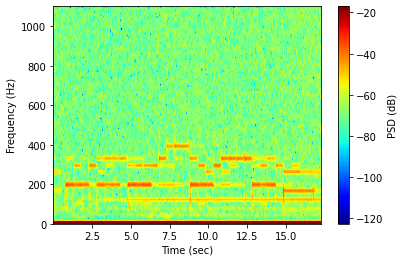

In [ ]:
vm.plot_spectogram(x,2200)

In [ ]:
vm.save_audio('test.wav',x)